# Samtools stats

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from pathlib import Path

run_names = {
    "aviti_ngi": "AVITI CB FS (NGI)",
    "aviti_hq": "AVITI CB (HQ)",
    "xplus_sns": "NovaSeqX+ (S&S)",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

basedir = Path("../analysis/nfcore_sarek_rerun")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")

In [3]:
def grep_file(file, key, columns=None):
    data = []
    with open(file) as f:
        for line in f:
            if line.startswith(key):
                data.append(line.strip().split("\t")[1:])

    if columns:
        data = pd.DataFrame(data, columns=columns)
    else: 
        data = pd.DataFrame(data)
    return data

def files(suffix):
    runs = ["aviti_ngi", "aviti_hq", "xplus_sns"]
    cells = ["KMS12BM", "MM1S", "OPM2", "REH"]

    for run in runs:
        for cell in cells:
            file = basedir / f"{run}/outdir/reports/samtools/{cell}/{cell}{suffix}"
            yield run, cell, file

def files_md():
    yield from files(suffix=".md.cram.stats")

def files_recal():
    yield from files(suffix=".recal.cram.stats")


## Insert sizes

In [ ]:
ins = [] 
columns = ["size", "total pairs", "inward oriented pairs", "outward orient pairs", "other orientation pairs"]
for run, cell, file in files_md():
    d = grep_file(file, "IS", columns)
    d = d.astype({c: int for c in columns})
    d["run"] = run
    d["Cell line"] = cell

    # Filter shortest inserts
    d = d[d["size"] > 20]
    # Normalize
    d["% of pairs"] = 100 * d["total pairs"] / d["total pairs"].sum()
    d["total_bases"] = 100 * d["total pairs"] * d["size"] 
    d["% of bases"] = 100 * d["total_bases"] / d["total_bases"].sum()
    d["cumula_bases"] = np.cumsum(d["% of bases"])
    d["cumula_pairs"] = np.cumsum(d["% of bases"])
    ins.append(d)

ins = pd.concat(ins).reset_index()
ins["Data source"] = ins["run"].replace(run_names)  

ins["% out"] = 100 * ins["outward orient pairs"] / ins["total pairs"]
ins["% in"] = 100 * ins["inward oriented pairs"] / ins["total pairs"]
ins["% other"] = 100 * ins["other orientation pairs"] / ins["total pairs"]
ins.head()

,index,size,total pairs,inward oriented pairs,outward orient pairs,other orientation pairs,run,Cell line,% of pairs,total_bases,% of bases,cumula_bases,cumula_pairs,Data source,% out,% in,% other
0,21,21,3282,345,2918,19,aviti_ngi,KMS12BM,0.001761,6892200,0.000094,0.000094,0.000094,AVITI CB FS (NGI),88.909202,10.511883,0.578915
1,22,22,2937,315,2610,12,aviti_ngi,KMS12BM,0.001576,6461400,0.000088,0.000183,0.000183,AVITI CB FS (NGI),88.866190,10.725230,0.408580
2,23,23,2737,170,2553,14,aviti_ngi,KMS12BM,0.001469,6295100,0.000086,0.000269,0.000269,AVITI CB FS (NGI),93.277311,6.211180,0.511509
3,24,24,2532,76,2445,11,aviti_ngi,KMS12BM,0.001359,6076800,0.000083,0.000352,0.000352,AVITI CB FS (NGI),96.563981,3.001580,0.434439
4,25,25,2530,63,2455,12,aviti_ngi,KMS12BM,0.001358,6325000,0.000087,0.000439,0.000439,AVITI CB FS (NGI),97.035573,2.490119,0.474308


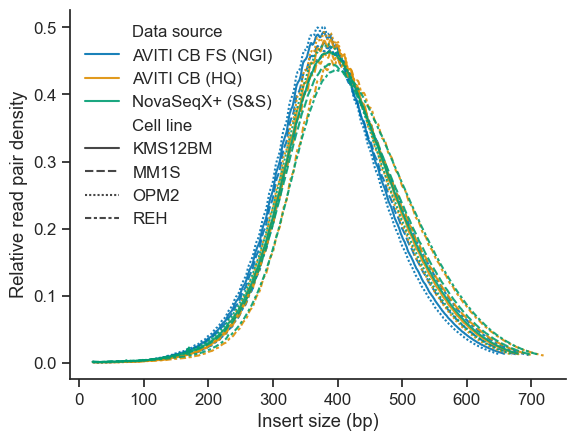

In [ ]:
ax = sns.lineplot(data=ins, x="size", y="% of pairs", hue="Data source", style="Cell line", hue_order=run_names.values(), alpha=0.9)
ax.set_xlabel("Insert size (bp)")
ax.set_ylabel("Relative read pair density")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0, 1))
plt.legend(frameon=False, framealpha=0)

fig = ax.get_figure()
fig.savefig(figdir / "insert_size_vs_reads_density.svg", backend='svg', 
            transparent=True, dpi=300, bbox_inches='tight')

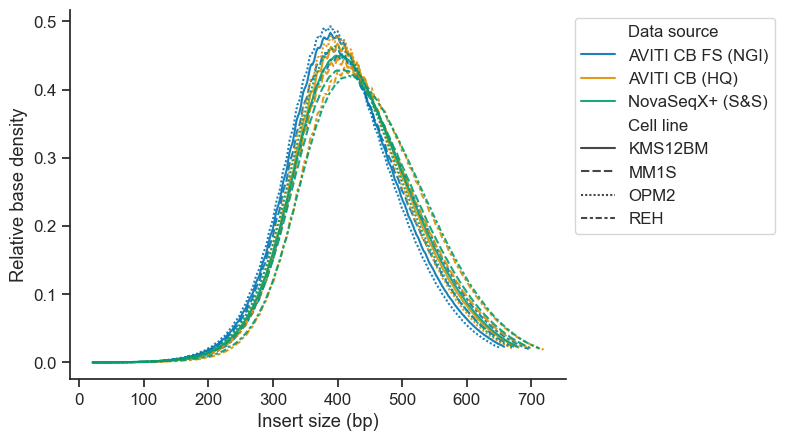

In [ ]:
ax = sns.lineplot(data=ins, x="size", y="% of bases", hue="Data source", 
                  style="Cell line", hue_order=run_names.values(),
                 alpha=0.9)
ax.set_xlabel("Insert size (bp)")
ax.set_ylabel("Relative base density")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Orientation

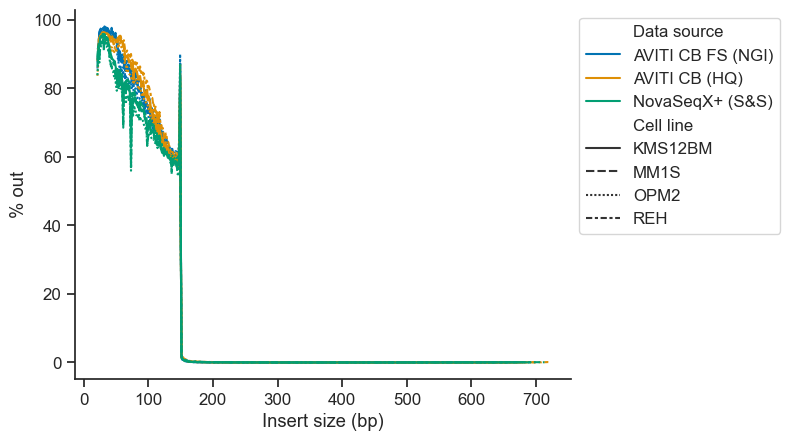

In [ ]:
ax = sns.lineplot(data=ins, x="size", y="% out", hue="Data source", style="Cell line", hue_order=run_names.values())
ax.set_xlabel("Insert size (bp)")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

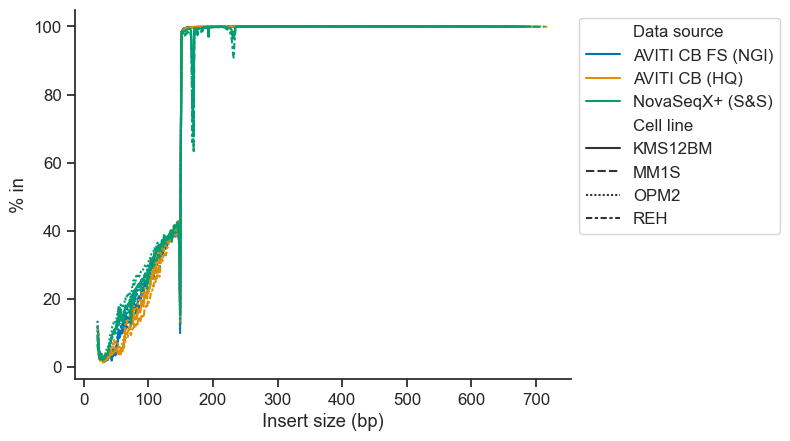

In [ ]:
ax = sns.lineplot(data=ins, x="size", y="% in", hue="Data source", style="Cell line", hue_order=run_names.values())
ax.set_xlabel("Insert size (bp)")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Mean and median size

In [ ]:
ins_agg = []
for group, d in ins.groupby(["Data source", "Cell line"]):
    mean = (d["size"] * d["total pairs"]).sum() / d["total pairs"].sum()
    d = d.sort_values(by="size")
    median = d["size"][np.cumsum(d["total pairs"]) > d["total pairs"].sum()/2].values[0]
    #print(*group, median, mean, sep="\t")
    ins_agg.append((*group, median, mean))

ins_agg = pd.DataFrame(ins_agg, columns=["Data source", "Cell line", "Mean", "Median"])
ins_agg

,Data source,Cell line,Mean,Median
0,AVITI CB (HQ),KMS12BM,401,406.074291
1,AVITI CB (HQ),MM1S,405,411.338014
2,AVITI CB (HQ),OPM2,396,400.179568
3,AVITI CB (HQ),REH,419,425.640384
4,AVITI CB FS (NGI),KMS12BM,388,392.255178
5,AVITI CB FS (NGI),MM1S,393,397.657927
6,AVITI CB FS (NGI),OPM2,384,387.318217
7,AVITI CB FS (NGI),REH,405,410.642257
8,NovaSeqX+ (S&S),KMS12BM,401,405.916497
9,NovaSeqX+ (S&S),MM1S,407,411.970898


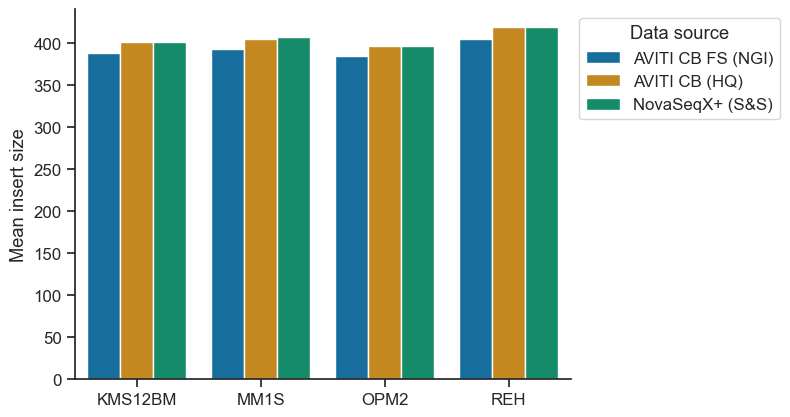

In [ ]:
ax = sns.barplot(ins_agg, x="Cell line", y="Mean", hue="Data source", hue_order=run_names.values())
ax.set_ylabel("Mean insert size")
ax.set_xlabel("")
sns.move_legend(ax, loc="best", bbox_to_anchor=(1,1))

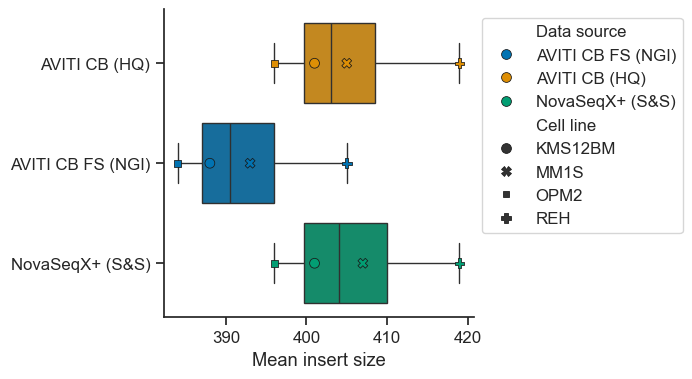

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.boxplot(ins_agg, y="Data source", x="Mean", hue="Data source", 
                 hue_order=run_names.values(), ax=ax, zorder=-1)
ax = sns.scatterplot(ins_agg, y="Data source", x="Mean", hue="Data source", 
                   hue_order=run_names.values(), ax=ax, color="k", style="Cell line",
                    edgecolors="k", s=50)
ax.set_xlabel("Mean insert size")
ax.set_ylabel("")
sns.move_legend(ax, loc="best", bbox_to_anchor=(1,1))

### Periodicity RCA
"strong template length-dependent amplification efficiency bias of RCA with the same periodicity as B-DNA" https://pmc.ncbi.nlm.nih.gov/articles/PMC5778537/

B-DNA: 10-10.5 bp per turn. https://doi.org/10.1073%2Fpnas.76.1.200 


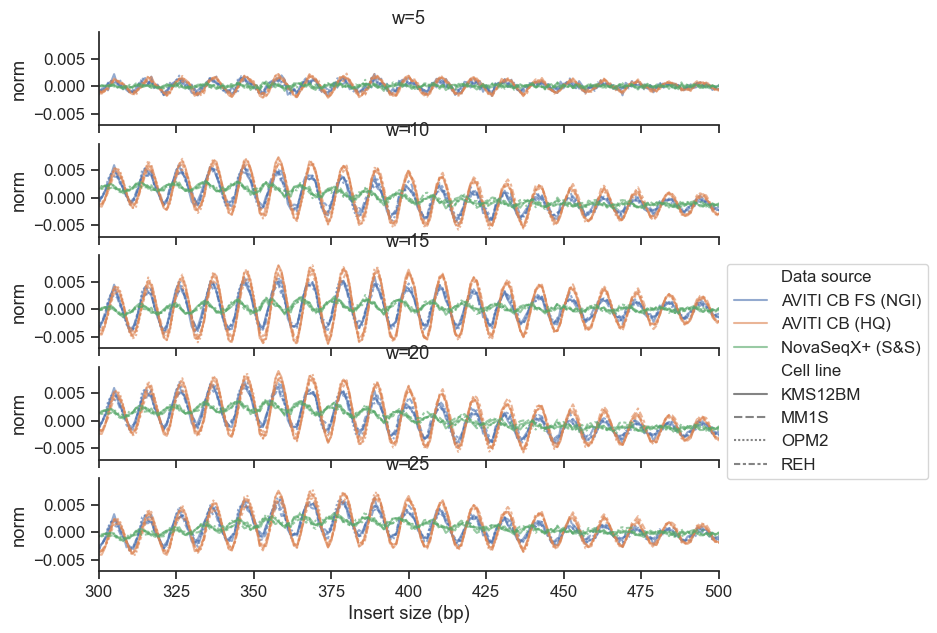

In [ ]:
fig, axes = plt.subplots(nrows=5, figsize=(8,7), sharey=True, sharex=True)
windows = [5,10,15,20,25]
sns.set_style("whitegrid")
for ax, w in zip(axes.ravel(), windows):
    ax.set_title(f"{w=}")
    ins["norm"] = ins.groupby(["Data source", "Cell line"])["% of pairs"].transform(lambda x: x - x.rolling(w, center=True).mean())
    show_legend = w == windows[2]
    ax = sns.lineplot(data=ins, x="size", y="norm", hue="Data source", hue_order=run_names.values(), style="Cell line", ax=ax, legend=show_legend, alpha=0.6)
    ax.set_xlabel("Insert size (bp)")
    ax.set_xlim(300, 500)
    if show_legend:
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

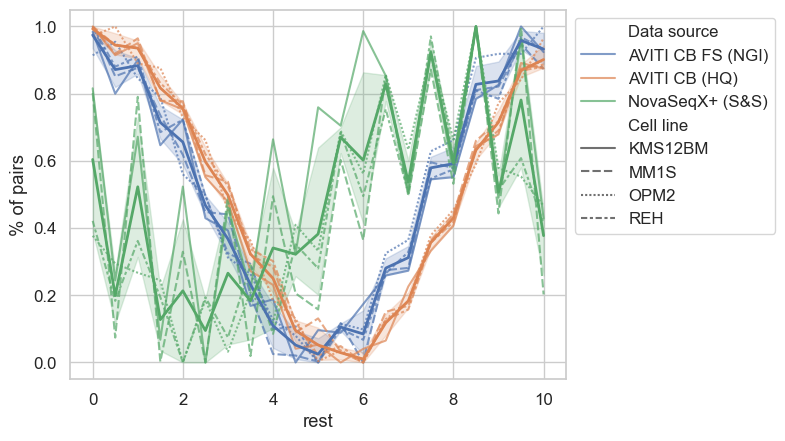

In [ ]:
d = ins[(ins["size"] > 100) & (ins["size"] < 800)].copy()
d["rest"] = d["size"].apply(lambda x: (x-1) % 10.5)
d = d.sort_values(by="rest")
d = d.groupby(["rest", "Data source", "Cell line"], as_index=False).agg({"total pairs":"sum", "total_bases":"sum"})
d["% of pairs"] = d.groupby(["Data source", "Cell line"])["total pairs"].transform(lambda x: (x-x.min())/(x.max() - x.min()))
ax = sns.lineplot(d, x="rest", y="% of pairs", hue="Data source", hue_order=run_names.values(), style="Cell line", alpha=0.7)
ax = sns.lineplot(d, x="rest", y="% of pairs", hue="Data source", hue_order=run_names.values(), lw=2, legend=False)
plt.legend(bbox_to_anchor=(1,1))

## GC content

In [ ]:
# Read 1
gcr1 = [] 
columns = ["GC percentile", "reads"]
for run, cell, file in files_md():
    d = grep_file(file, "GCF", columns)
    d = d.astype({"GC percentile": float, "reads": int})
    d["run"] = run
    d["cell"] = cell

    # Normalize
    d["% of reads"] = d["reads"] / d["reads"].sum()
    gcr1.append(d)

gcr1 = pd.concat(gcr1).reset_index(drop=True)
gcr1["Read"] = "R1"

gcr2 = [] 
columns = ["GC percentile", "reads"]
for run, cell, file in files_md():
    d = grep_file(file, "GCL", columns)
    d = d.astype({"GC percentile": float, "reads": int})
    d["run"] = run
    d["Cell line"] = cell

    # Normalize
    d["% of reads"] = d["reads"] / d["reads"].sum()
    gcr2.append(d)

gcr2 = pd.concat(gcr2).reset_index(drop=True)
gcr2["Read"] = "R2"
gc = pd.concat([gcr1, gcr2]).reset_index(drop=True)
gc["Data source"] = gc["run"].replace(run_names)
gc

,GC percentile,reads,run,cell,% of reads,Read,Cell line,Data source
0,0.25,797,aviti_ngi,KMS12BM,0.000004,R1,NaN,AVITI CB FS (NGI)
1,0.75,552,aviti_ngi,KMS12BM,0.000003,R1,NaN,AVITI CB FS (NGI)
2,1.26,690,aviti_ngi,KMS12BM,0.000004,R1,NaN,AVITI CB FS (NGI)
3,2.01,758,aviti_ngi,KMS12BM,0.000004,R1,NaN,AVITI CB FS (NGI)
4,2.76,902,aviti_ngi,KMS12BM,0.000005,R1,NaN,AVITI CB FS (NGI)
...,...,...,...,...,...,...,...,...
3595,96.73,109086,xplus_sns,NaN,0.000171,R2,REH,NovaSeqX+ (S&S)
3596,97.49,142510,xplus_sns,NaN,0.000223,R2,REH,NovaSeqX+ (S&S)
3597,98.24,181439,xplus_sns,NaN,0.000284,R2,REH,NovaSeqX+ (S&S)
3598,98.74,237039,xplus_sns,NaN,0.000371,R2,REH,NovaSeqX+ (S&S)


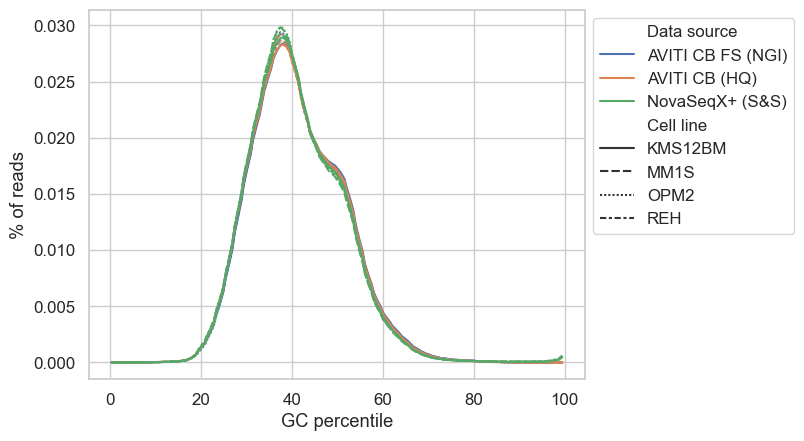

In [ ]:
d = gc.groupby(["GC percentile", "Cell line", "Data source"], as_index=False)["reads"].sum()
d["% of reads"] = d.groupby(["Cell line", "Data source"])["reads"].transform(lambda x: x/x.sum()) 
ax = sns.lineplot(d, x="GC percentile", y="% of reads", hue="Data source", style="Cell line", hue_order=run_names.values())
ax.set_xlabel("GC percentile")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Compare to reference

In [ ]:
%%bash 
wget https://raw.githubusercontent.com/MultiQC/MultiQC/refs/heads/main/multiqc/modules/fastqc/fastqc_theoretical_gc/fastqc_theoretical_gc_hg38_genome.txt

--2025-02-19 13:39:08--  https://raw.githubusercontent.com/MultiQC/MultiQC/refs/heads/main/multiqc/modules/fastqc/fastqc_theoretical_gc/fastqc_theoretical_gc_hg38_genome.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 921 [text/plain]
Saving to: ‘fastqc_theoretical_gc_hg38_genome.txt’

     0K                                                       100% 18.3M=0s

2025-02-19 13:39:08 (18.3 MB/s) - ‘fastqc_theoretical_gc_hg38_genome.txt’ saved [921/921]



In [ ]:
gcref = pd.read_csv("fastqc_theoretical_gc_hg38_genome.txt", sep="\t", names=["GC", "Fraction"], header=0).set_index("GC")
print(gcref)
gcref["GRCh38"] = (gcref["Fraction"] / gcref["Fraction"].sum()) * (len(gcref) / len(gc["GC percentile"].unique()))
gcref["GRCh38"].sum()


     Fraction
GC           
0       0.005
1       0.004
2       0.004
3       0.005
4       0.006
..        ...
96      0.000
97      0.000
98      0.000
99      0.000
100     0.000

[101 rows x 1 columns]


np.float64(0.6733333333333333)

<Axes: xlabel='GC', ylabel='% of reads'>

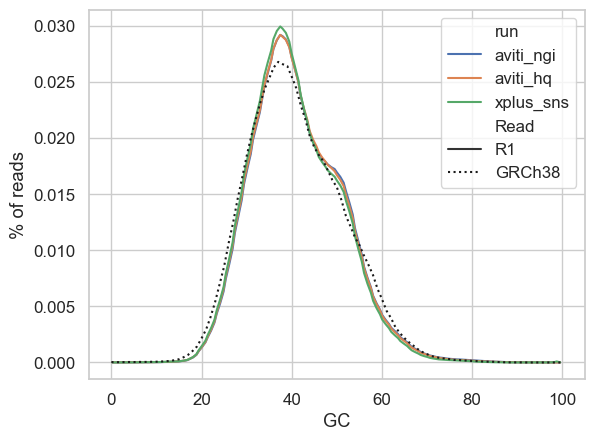

In [ ]:
ax = sns.lineplot(data=gc[gc["cell"] == "MM1S"], x="GC percentile", y="% of reads", style="Read", hue="run")
gcref.loc[:,["GRCh38"]].plot.line(ax=ax, color="k", style=":")

## Reported base quality

In [4]:
bq = [] 

for run, cell, file in files_md():
    d1 = grep_file(file, "FFQ")
    d1 = d1.astype({c: int for c in d1.columns})
    d2 = grep_file(file, "LFQ")
    d2 = d2.astype({c: int for c in d2.columns})
    d2[0] += d1[0].max()
    d = pd.concat([d1,d2])
    quals = list(range(0,d.shape[1]-1))
    columns = ["cycle"] + quals
    d.columns = columns
    bases = d[quals].sum(axis=0).values
    norm = bases / bases.sum()
    cumsum = [100] + list(100 * (1 - np.cumsum(norm)))
    
    bq.append(pd.DataFrame({
        "run": run,
        "Cell line": cell,
        "quals": quals,
        "bases": bases,
        "norm": norm,
        "cumsum": cumsum[:-1],
    }))
    
bq = pd.concat(bq).reset_index(drop=True)
bq["Data source"] = bq["run"].replace(run_names)
bq.head()

,run,Cell line,quals,bases,norm,cumsum,Data source
0,aviti_ngi,KMS12BM,0,8568562,1.502126e-04,100.000000,AVITI CB FS (NGI)
1,aviti_ngi,KMS12BM,1,19849,3.479662e-07,99.984979,AVITI CB FS (NGI)
2,aviti_ngi,KMS12BM,2,1652262,2.896525e-05,99.984944,AVITI CB FS (NGI)
3,aviti_ngi,KMS12BM,3,29283393,5.133573e-04,99.982047,AVITI CB FS (NGI)
4,aviti_ngi,KMS12BM,4,38503386,6.749899e-04,99.930712,AVITI CB FS (NGI)


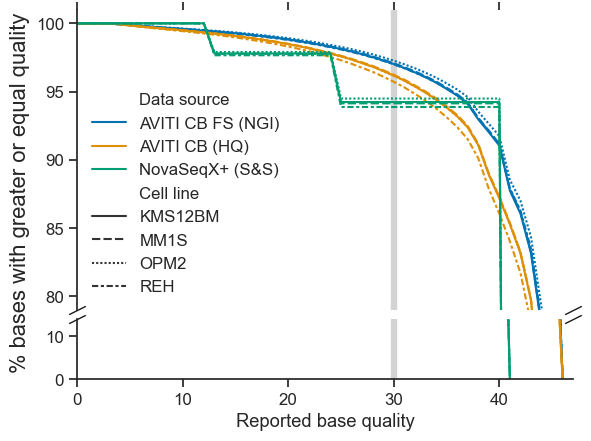

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, height_ratios=[5,1])
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes
ax1.axvspan(29.75, 30.25, color="lightgrey")
ax2.axvspan(29.75, 30.25, color="lightgrey")

ax1 = sns.lineplot(bq, x="quals", y="cumsum", hue="Data source", style="Cell line", hue_order=run_names.values(), ax=ax1)
_ = ax1.set(xlabel="Reported base quality", ylabel="",
       xlim=(0,bq["quals"].max()+1))
fig.supylabel("% bases with greater or equal quality")
ax1.legend(frameon=False, framealpha=0)

sns.move_legend(ax1, bbox_to_anchor=(0,0), loc="lower left")

ax2 = sns.lineplot(bq, x="quals", y="cumsum", hue="Data source", style="Cell line", hue_order=run_names.values(), ax=ax2, legend=False)
_ = ax2.set(xlabel="Reported base quality", ylabel="", 
       xlim=(0,bq["quals"].max()+1))

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(79, 101)  # outliers only
ax2.set_ylim(0, 14)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the Axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the Axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

fig.savefig(figdir / "reported_base_quality_cumulative_density.svg", backend='svg', 
            transparent=True, dpi=300, bbox_inches='tight')

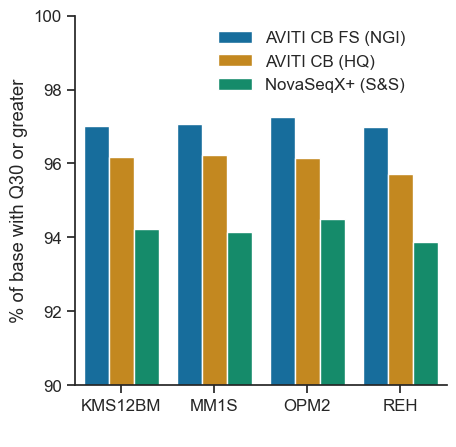

In [5]:
fig, ax = plt.subplots(figsize=(4.8,4.8))
ax = sns.barplot(bq[bq["quals"] == 30], x="Cell line", y="cumsum", ax=ax,
                 hue="Data source", hue_order=run_names.values())
ax.set_ylabel("% of base with Q30 or greater")
ax.set_ylim(90,100)
ax.set_xlabel(" ")
ax.legend(frameon=False, framealpha=0)
sns.move_legend(ax, bbox_to_anchor=(0.93,1), loc="upper right")
fig = ax.get_figure()
fig.savefig(figdir / "reported_base_quality_geQ30.svg", backend='svg', 
            transparent=True, dpi=300, bbox_inches='tight')

/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_33439/2137008140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["cumsum"] = 100 - d["cumsum"]


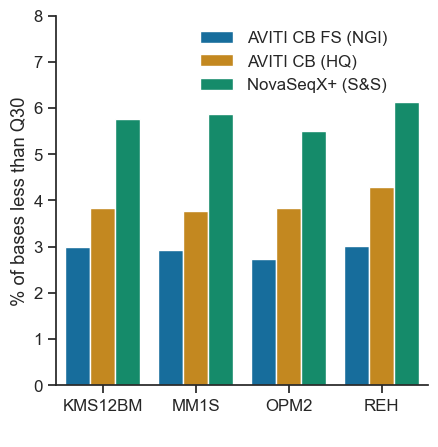

In [11]:
fig, ax = plt.subplots(figsize=(4.8,4.8))
d = bq[bq["quals"] == 30]
d["cumsum"] = 100 - d["cumsum"] 
ax = sns.barplot(d, x="Cell line", y="cumsum", ax=ax,
                 hue="Data source", hue_order=run_names.values())
ax.set_ylabel("% of bases less than Q30")
ax.set_xlabel(" ")
ax.set_ylim(0,8)
ax.legend(frameon=False, framealpha=0)
sns.move_legend(ax, bbox_to_anchor=(0.93,1), loc="upper right")
fig = ax.get_figure()
#fig.savefig(figdir / "reported_base_quality_geQ30.svg", backend='svg', 
#            transparent=True, dpi=300, bbox_inches='tight')

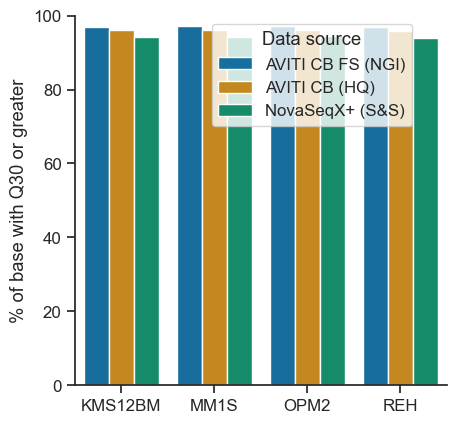

In [8]:
fig, ax = plt.subplots(figsize=(4.8,4.8))
ax = sns.barplot(bq[bq["quals"] == 30], x="Cell line", y="cumsum", ax=ax,
                 hue="Data source", hue_order=run_names.values())
ax.set_ylabel("% of base with Q30 or greater")
ax.set_ylim(0,100)
ax.set_xlabel(" ")
#ax.legend(frameon=False, framealpha=0)
sns.move_legend(ax, bbox_to_anchor=(0.93,1), loc="upper right")
#fig = ax.get_figure()
#fig.savefig(figdir / "reported_base_quality_geQ30.svg", backend='svg', 
#            transparent=True, dpi=300, bbox_inches='tight')

### Binning Element qualities
https://knowledge.illumina.com/instrumentation/novaseq-x-x-plus/instrumentation-novaseq-x-x-plus-reference_material-list/000008320 

Bin

Q Score Range
0: 0-2
12: 3-17
24: 18-29
40: 30+

/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_33439/3719055102.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d.groupby(["Data source", "Cell line", "qbin"],as_index=False).agg({"bases":"sum", "norm": "sum"})


(0.9, 1.0)

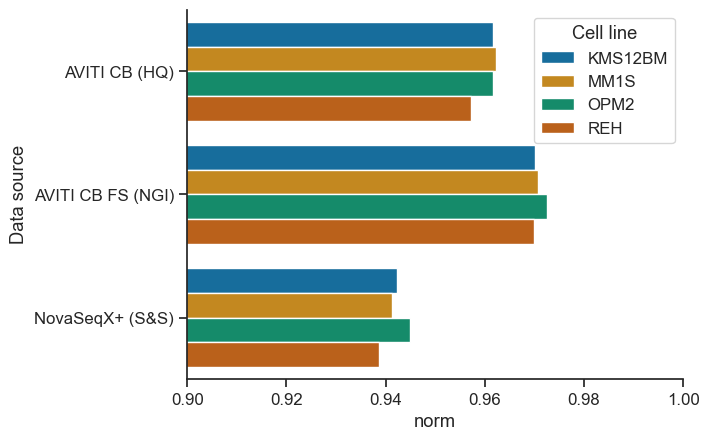

In [23]:
d = bq.copy()
bins = [-1,2,17,29,46]
labels = [0, 12, 24, 40]
d["qbin"] = pd.cut(d["quals"], bins=bins, labels=labels)
d = d.groupby(["Data source", "Cell line", "qbin"],as_index=False).agg({"bases":"sum", "norm": "sum"})
d["cumula"] = d.groupby(["Data source", "Cell line"])["bases"].transform(lambda x: 1-(np.cumsum(x)/x.sum()))
ax = sns.barplot(d[d["qbin"] == 40], hue="Cell line", x="norm", y="Data source")
sns.move_legend(ax, bbox_to_anchor=(1,1), loc="best")
ax.set_xlim(0.9,1)

<Axes: xlabel='qbin', ylabel='norm'>

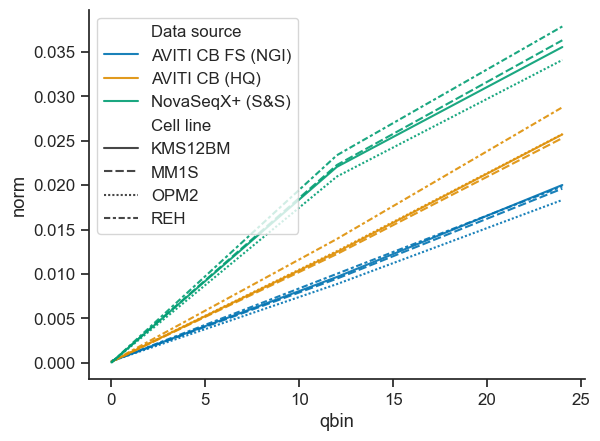

In [26]:
sns.lineplot(d[d["qbin"] != 40], x="qbin", y="norm", hue="Data source", style="Cell line",
                hue_order=run_names.values(), alpha=0.9)


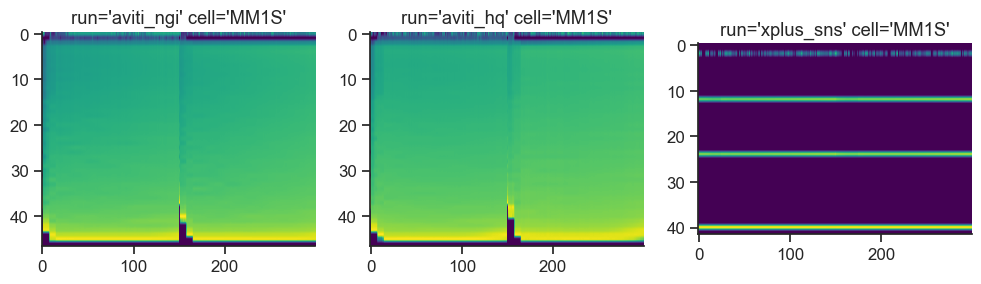

In [224]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,10))
files_mm1s = [(run, cell, file) for run, cell, file in files_md() if cell == "MM1S"]
for ax, (run, cell, file) in zip(axes.radvel(), files_mm1s):
    d1 = grep_file(file, "FFQ")
    d1 = d1.astype({c: int for c in d1.columns})
    d2 = grep_file(file, "LFQ")
    d2 = d2.astype({c: int for c in d2.columns})
    d2[0] += d1[0].max()
    d = pd.concat([d1,d2])
    quals = list(range(0,d.shape[1]-1))
    columns = ["cycle"] + quals
    d.columns = columns
    d[quals] += 1
    qualm = d[quals].T.apply(np.log10)
    
    ax.set_title(f"{run=} {cell=}")
    ax.imshow(qualm, aspect=5, cmap="viridis")
    


## Mapping quality

In [251]:
mapq = [] 
for run, cell, file in files_md():
    d = grep_file(file, "MAPQ")
    d = d.astype({c: int for c in d.columns})
    d.columns = ["MAPQ", "Reads"]
    
    # Ignore reads with MAPQ=0 as these could not be confidently placed
    d = d[d["MAPQ"] > 0]
    
    d["Relative reads"] = 100 * d["Reads"] / d["Reads"].sum()
    d = d[::-1]
    d["% Reads ge MAPQ"] = np.cumsum(d["Relative reads"])
    d["run"] = run
    d["Cell line"] = cell

    mapq.append(d)

mapq = pd.concat(mapq).reset_index(drop=True)
mapq["Data source"] = mapq["run"].replace(run_names)  
mapq.head()

,MAPQ,Reads,Relative reads,% Reads ge MAPQ,run,Cell line,Data source
0,60,336633248,95.532179,95.532179,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
1,59,172658,0.048998,95.581177,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
2,58,51666,0.014662,95.595839,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
3,57,385855,0.109501,95.705340,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
4,56,63293,0.017962,95.723302,aviti_ngi,KMS12BM,AVITI CB FS (NGI)


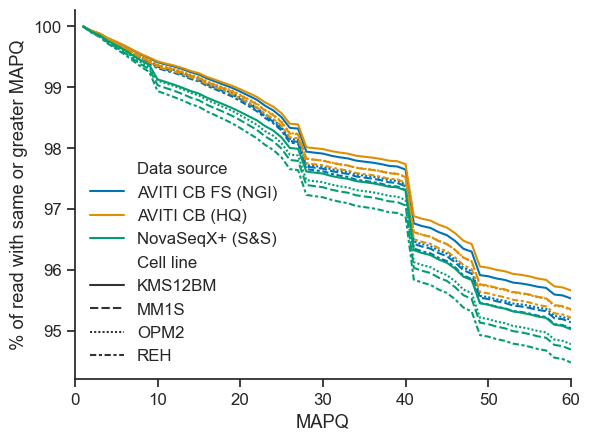

In [429]:
ax = sns.lineplot(mapq, x="MAPQ", y="% Reads ge MAPQ", hue="Data source", hue_order=run_names.values(), 
                  style="Cell line")
ax.set_ylabel("% of read with same or greater MAPQ") 
ax.set_xlim(0,60)
ax.legend(frameon=False, framealpha=0)

fig = ax.get_figure()
fig.savefig(figdir / "mapq_cumulartive_read_density.svg", backend='svg', transparent=True, dpi=300, bbox_inches='tight')


# Summary numbers


In [314]:
sn = [] 

for run, cell, file in files_md():
    d = grep_file(file, "SN")
    d.columns = ["Stat", "Value", "Extra"]
    d["Stat"] = d["Stat"].str[:-1]
    d["Value"] = d["Value"].astype(float)
    d = d.drop(columns="Extra")
    d = d.set_index("Stat").T
    #d = d.astype({c: int for c in d.columns})
    d["run"] = run
    d["Cell line"] = cell
    sn.append(d)
    
sn = pd.concat(sn).reset_index(drop=True)
sn["Data source"] = sn["run"].replace(run_names)
#sn = sn.set_index(["Data source", "Cell line"])

sn["% mapped"] = 100 * sn["reads mapped"] / sn["sequences"]
sn["% unmapped"] = 100 * sn["reads unmapped"] / sn["sequences"]
sn["% duplicates"] = 100 * sn["reads duplicated"] / sn["sequences"]
sn["% MAPQ=0"] = 100 * sn["reads MQ0"] / sn["sequences"]
sn.describe()

Stat,raw total sequences,filtered sequences,sequences,is sorted,1st fragments,last fragments,reads mapped,reads mapped and paired,reads unmapped,reads properly paired,...,insert size standard deviation,inward oriented pairs,outward oriented pairs,pairs with other orientation,pairs on different chromosomes,percentage of properly paired reads (%),% mapped,% unmapped,% duplicates,% MAPQ=0
count,1.200000e+01,12.0,1.200000e+01,12.0,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,...,12.000000,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,12.000000,12.000000,12.000000,12.000000,12.000000
mean,9.391212e+08,0.0,9.391212e+08,1.0,4.695606e+08,4.695606e+08,9.371604e+08,9.361459e+08,1.960737e+06,9.221624e+08,...,92.875000,4.604014e+08,2.365038e+06,5.739655e+05,4.732517e+06,98.308333,99.813686,0.186314,9.057511,4.079422
std,4.484429e+08,0.0,4.484429e+08,0.0,2.242215e+08,2.242215e+08,4.470593e+08,4.465753e+08,1.549139e+06,4.384126e+08,...,3.151947,2.188329e+08,1.179039e+06,3.468624e+05,3.296666e+06,0.372847,0.073780,0.073780,10.031717,0.155711
min,3.264107e+08,0.0,3.264107e+08,1.0,1.632054e+08,1.632054e+08,3.258778e+08,3.254533e+08,5.329570e+05,3.209633e+08,...,87.900000,1.602809e+08,8.348480e+05,1.370160e+05,1.383854e+06,97.600000,99.691424,0.120298,0.985091,3.802169
25%,4.190171e+08,0.0,4.190171e+08,1.0,2.095085e+08,2.095085e+08,4.184787e+08,4.180489e+08,5.448112e+05,4.132649e+08,...,90.675000,2.062491e+08,1.134522e+06,2.255738e+05,1.537486e+06,98.050000,99.733830,0.133572,1.322981,3.970176
50%,1.051554e+09,0.0,1.051554e+09,1.0,5.257768e+08,5.257768e+08,1.050227e+09,1.049204e+09,1.355872e+06,1.036739e+09,...,93.100000,5.178517e+08,2.385492e+06,5.707865e+05,3.847417e+06,98.450000,99.857446,0.142554,3.510211,4.096682
75%,1.304821e+09,0.0,1.304821e+09,1.0,6.524103e+08,6.524103e+08,1.301127e+09,1.299597e+09,3.643610e+06,1.273704e+09,...,94.850000,6.357714e+08,3.487545e+06,7.877865e+05,8.471792e+06,98.600000,99.866428,0.266170,21.541939,4.171415
max,1.573794e+09,0.0,1.573794e+09,1.0,7.868971e+08,7.868971e+08,1.569468e+09,1.567833e+09,4.325730e+06,1.543348e+09,...,97.800000,7.703548e+08,4.131056e+06,1.101128e+06,9.488510e+06,98.700000,99.879702,0.308576,23.939115,4.333681


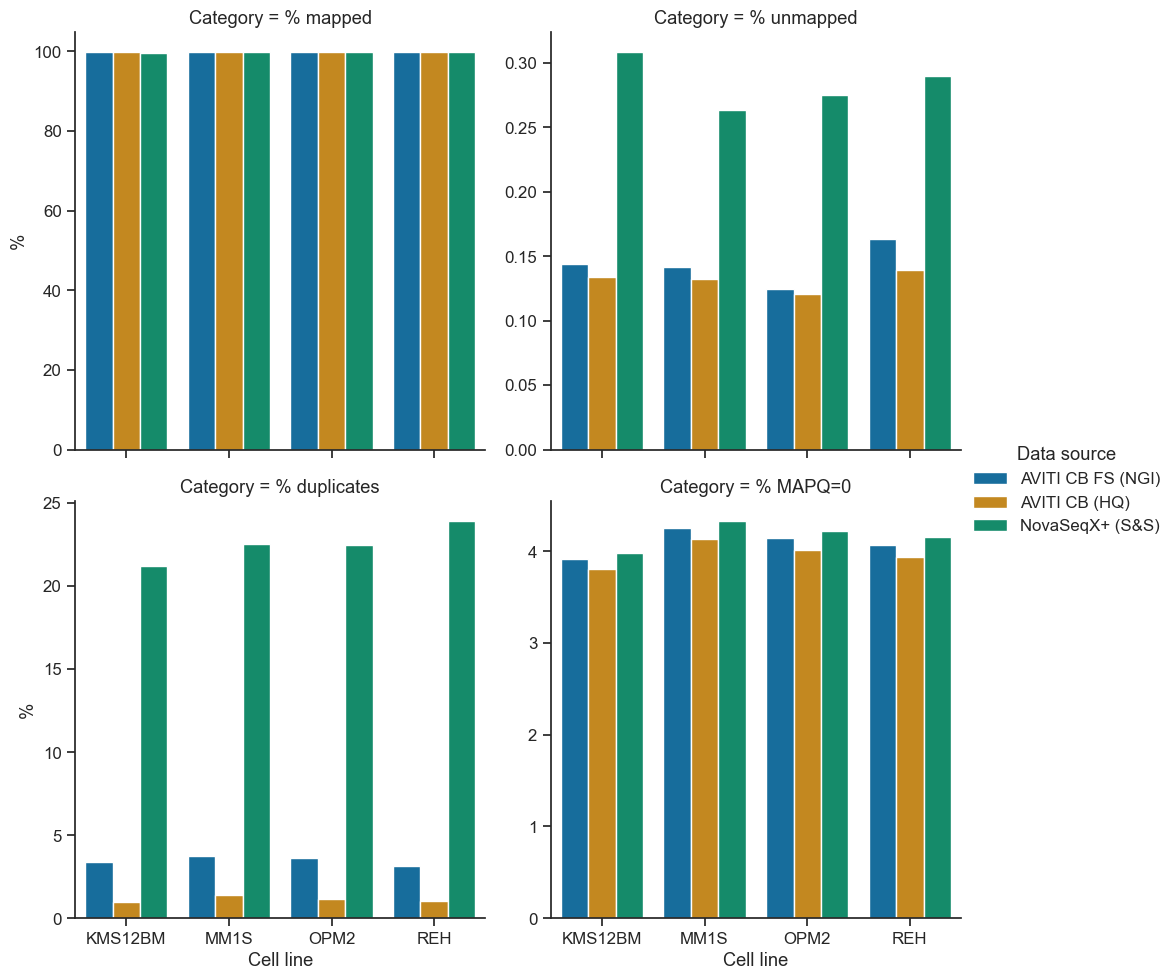

In [320]:
cols = ["% mapped", "% unmapped", "% duplicates", "% MAPQ=0"]
d = sn.melt(id_vars=["Data source", "Cell line"], value_name="%", 
            value_vars=cols, var_name="Category")

sns.catplot(d, kind="bar", x="Cell line", y="%", hue="Data source", 
            col="Category", sharey=False, col_wrap=2, hue_order=run_names.values())

In [322]:
sn.style

Stat,raw total sequences,filtered sequences,sequences,is sorted,1st fragments,last fragments,reads mapped,reads mapped and paired,reads unmapped,reads properly paired,reads paired,reads duplicated,reads MQ0,reads QC failed,non-primary alignments,supplementary alignments,total length,total first fragment length,total last fragment length,bases mapped,bases mapped (cigar),bases trimmed,bases duplicated,mismatches,error rate,average length,average first fragment length,average last fragment length,maximum length,maximum first fragment length,maximum last fragment length,average quality,insert size average,insert size standard deviation,inward oriented pairs,outward oriented pairs,pairs with other orientation,pairs on different chromosomes,percentage of properly paired reads (%),run,Cell line,Data source,% mapped,% unmapped,% duplicates,% MAPQ=0
0,380286030.000000,0.000000,380286030.000000,1.000000,190143015.000000,190143015.000000,379740009.000000,379310530.000000,546021.000000,374937982.000000,380286030.000000,12836317.000000,14904207.000000,0.000000,0.000000,1401922.000000,57042904500.000000,28521452250.000000,28521452250.000000,56961001350.000000,56789018800.000000,0.000000,1925447550.000000,217962802.000000,0.003838,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,43.100000,392.100000,89.400000,187124500.000000,1006059.000000,137016.000000,1387690.000000,98.600000,aviti_ngi,KMS12BM,AVITI CB FS (NGI),99.856418,0.143582,3.375437,3.919210
1,382389406.000000,0.000000,382389406.000000,1.000000,191194703.000000,191194703.000000,381848224.000000,381421500.000000,541182.000000,376503962.000000,382389406.000000,14214775.000000,16276432.000000,0.000000,0.000000,1600308.000000,57358410900.000000,28679205450.000000,28679205450.000000,57277233600.000000,57090312830.000000,0.000000,2132216250.000000,241424219.000000,0.004229,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,43.100000,397.400000,92.600000,187863794.000000,1038504.000000,221034.000000,1587418.000000,98.500000,aviti_ngi,MM1S,AVITI CB FS (NGI),99.858474,0.141526,3.717356,4.256507
2,431226316.000000,0.000000,431226316.000000,1.000000,215613158.000000,215613158.000000,430688901.000000,430258054.000000,537415.000000,425518570.000000,431226316.000000,15718136.000000,17868248.000000,0.000000,0.000000,1454790.000000,64683947400.000000,32341973700.000000,32341973700.000000,64603335150.000000,64412889603.000000,0.000000,2357720400.000000,241500221.000000,0.003749,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,43.200000,387.200000,87.900000,212377511.000000,1166528.000000,200227.000000,1384761.000000,98.700000,aviti_ngi,OPM2,AVITI CB FS (NGI),99.875375,0.124625,3.644985,4.143589
3,326410728.000000,0.000000,326410728.000000,1.000000,163205364.000000,163205364.000000,325877771.000000,325453324.000000,532957.000000,320963316.000000,326410728.000000,10324473.000000,13264168.000000,0.000000,0.000000,1306021.000000,48961609200.000000,24480804600.000000,24480804600.000000,48881665650.000000,48720272558.000000,0.000000,1548670950.000000,207197664.000000,0.004253,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,43.100000,410.300000,93.600000,160280873.000000,834848.000000,227087.000000,1383854.000000,98.300000,aviti_ngi,REH,AVITI CB FS (NGI),99.836722,0.163278,3.163031,4.063643
4,1077698526.000000,0.000000,1077698526.000000,1.000000,538849263.000000,538849263.000000,1076253220.000000,1075163312.000000,1445306.000000,1062705876.000000,1077698526.000000,10616316.000000,40975923.000000,0.000000,0.000000,3943904.000000,161654778900.000000,80827389450.000000,80827389450.000000,161437983000.000000,160985094774.000000,0.000000,1592447400.000000,722657638.000000,0.004489,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,42.600000,405.900000,91.100000,530860284.000000,2415598.000000,459834.000000,3845940.000000,98.600000,aviti_hq,KMS12BM,AVITI CB (HQ),99.865890,0.134110,0.985091,3.802169
5,1050671668.000000,0.000000,105

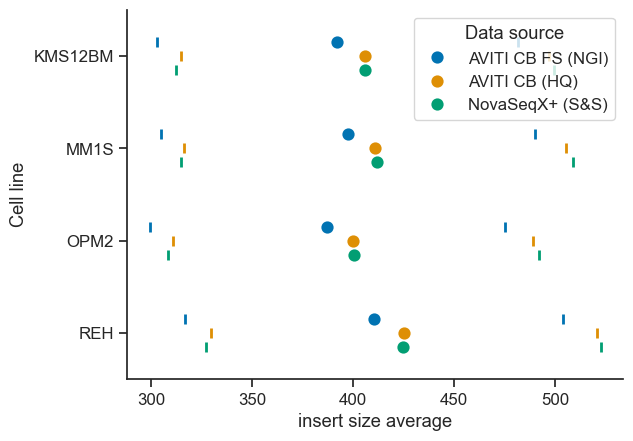

In [345]:
sn["in-sd"] = sn["insert size average"] - sn["insert size standard deviation"]
sn["in+sd"] = sn["insert size average"] + sn["insert size standard deviation"]

ax = sns.pointplot(sn, y="Cell line", x="insert size average", hue="Data source", 
              hue_order=run_names.values(), dodge=0.3, linestyles="none")

ax = sns.pointplot(sn, y="Cell line", x="in-sd", hue="Data source", marker="|",
              hue_order=run_names.values(), dodge=0.3, linestyles="none", ax=ax, legend=False)
ax = sns.pointplot(sn, y="Cell line", x="in+sd", hue="Data source", marker="|",
              hue_order=run_names.values(), dodge=0.3, linestyles="none", ax=ax, legend=False)
